In [1]:
import networkx as netx
import numpy as np
import DaPy as dp
from random import randint, random

In [2]:
data = dp.read('csv/Updates_NC.csv').data

 - read() in 0.037s.


In [3]:
def decode(val, code='utf-8'):
    if isinstance(val, bytes):
        return val.decode(code)
    return val
data = data.map(decode, cols=['报道时间', '省份', '城市', '消息来源'], inplace=True)

In [4]:
wuhan = data.query(' 城市 == "武汉市" and 报道时间 > "1月16日"').reverse()
wuhan = wuhan.groupby('报道时间', max, apply_col=['新增确诊', '新增出院', '新增死亡'])
wuhan.insert_row(0, ['1月17日', 17, 4, 0]) # 补充两条国家卫检委数据
wuhan.insert_row(6, ['1月23日', 62, 0, 17])# 补充两条国家卫检委数据
wuhan.show()

 报道时间 | 新增确诊 | 新增出院 | 新增死亡 
----------+----------+----------+----------
 1月17日  |    17    |    4     |    0     
 1月18日  |    4     |    3     |    0     
 1月19日  |    17    |    4     |    0     
 1月20日  |    77    |    5     |    1     
 1月21日  |    60    |    0     |    2     
 1月22日  |   105    |    3     |    8     
 1月23日  |    62    |    0     |    17    
 1月24日  |    70    |    3     |    6     
 1月25日  |    77    |    1     |    15    
 1月26日  |    46    |    8     |    7     
 1月27日  |    80    |    2     |    18    
 1月28日  |   892    |    3     |    22    
 1月29日  |   315    |    26    |    19    
 1月30日  |   356    |    7     |    25    
 1月31日  |   378    |    21    |    30    
  2月1日  |   576    |    36    |    33    
  2月2日  |   894    |    32    |    32    
  2月3日  |   1033   |    53    |    41    
  2月4日  |   1242   |    79    |    48    
  2月5日  |   1967   |    65    |    49    
  2月6日  |   1766   |    58    |    52    
  2月7日  |   1501   |   103    |    64    
  2月

#### SEID模型
易感数量 Susceptible：可能感染该病的健康人员数量

潜伏数量 Exposed：已感染病毒，但仍未表现出症状

患者数量 Infected： 已感染病毒，并表现出了症状

死者数量 Dead：死亡患者人数

治愈数量 Cured：治愈患者人数

潜伏感染率 $\alpha_{1}$：由潜伏者导致的传染概率

患者感染率 $\alpha_{2}$：由患者导致的传染概率

确诊率 $\beta$：潜伏者表现出症状的概率

治愈率 $\sigma$：患者治愈的概率

死亡率 $\gamma$：患者死亡的概率


$$
\frac{dS}{dt} = - \alpha_{1} E - \alpha_{2} I + \sigma I \\
\frac{dE}{dt} = \alpha_{1} E + \alpha_{2} I - \beta E\\
\frac{dI}{dt} = \beta E - \sigma I - \gamma I\\
\frac{dD}{dt} = \gamma E\\
\frac{dC}{dt} = \sigma I \\
$$

In [30]:
from scipy.optimize import dual_annealing, minimize
from sklearn.metrics import r2_score
from collections import namedtuple
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

SEIR_PARAM = namedtuple('SEIRparm', ['alpha1', 'alpha2', 'beta', 'sigma', 'gamma'])

class SEIR(object):
    def __init__(self, P=None):
        self.P = P
        
    def _forward(self, S, E, I, D, C, param, max_iter):
        a1, a2, b, s, g = param
        est = dp.Table(columns=['S', 'E', 'I', 'D', 'C'])
        for t in range(max_iter):
            S_ = S - a1 * E - a2 * I + s * I
            E_ = E + a1 * E + a2 * I - b * E
            I_ = I + b * E - s * I - g * I
            D_ = D + g * I
            C_ = C + s * I
            S, E, I, D, C = S_, E_, I_, D_, C_
            est.append_row([S, E, I, D, C])
        return est
    
    def _loss(self, obs, est):
        assert len(obs) == len(est)
        loss = ((np.log2(obs + 1) - np.log2(est + 1)) ** 2).sum()
        self.lossing.append(loss)
        return loss
    
    def _optimize(self, param, s, e, i, d, c, obs):
        est = self._forward(s, e, i, d, c, param, len(obs))
        return self._loss(obs, est['I', 'D', 'C'].toarray())
    
    def fit(self, initS, initE, initI, initD, initC, Y):
        self.lossing = []
        args = (initS, initE, initI, initD, initC, Y['确诊', '死亡', '治愈'].toarray())
        param = [(0, 1),] * 5
        # result = minimize(self._optimize, [random()] * 5, args=args, bounds=param)['x']
        result = dual_annealing(self._optimize, param, args=args, seed=30, maxiter=10)['x']
        self.P = SEIR_PARAM(*result)
    
    def score(self, initS, initE, initI, initD, initC, Y, plot=False):
        est = self.predict(initS, initE, initI, initD, initC, len(Y))['I', 'D', 'C']
        loss = self._loss(Y['确诊', '死亡', '治愈'].toarray(), est.toarray())
        est.columns = ['确诊', '死亡', '治愈']
        r1 = r2_score(Y['治愈'], est['治愈'])
        r2 = r2_score(Y['死亡'], est['死亡'])
        r3 = r2_score(Y['确诊'], est['确诊'])
        if plot:
            self.plot_predict(Y, est)
            print(' - 平均潜伏期为：%.2f天' % (1.0 / self.P.beta))
            print(' - 病毒再生基数：%.2f' % (self.P.alpha1 / self.P.beta + (self.P.alpha2 / self.P.sigma + self.P.alpha2 / self.P.gamma)/ 2))
            print(' - 确诊R2：%.4f' % r3)
            print(' - 死亡R2：%.4f' % r2)
            print(' - 治愈R2：%.4f' % r1)
            print(' - 模型R2：%.4f' % ((r1 + r2 + r3) / 3))
            print(' - 模型总误差：%.4f' % loss)
        return loss, (r1 + r2 + r3) / 3
    
    def plot_error(self):
        plt.plot(self.lossing, label=u'正确率')
        plt.legend()
        plt.show()
    
    def plot_predict(self, obs, est):
        for label, color in zip(obs.keys(), ['red', 'black', 'green']):
            plt.plot(obs[label], color=color)
            plt.plot(est[label], color=color, alpha=0.6, label=label)
            plt.legend()
            plt.show()
            
    def predict(self, initS, initE, initI, initD,initC, T):
        return self._forward(initS, initE, initI, initD, initC, self.P, T)

c:\python36\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log2


潜在患者：25.0000 | R2：0.8450 | 误差： 90.591710
潜在患者：100.0000 | R2：0.8450 | 误差： 90.591710


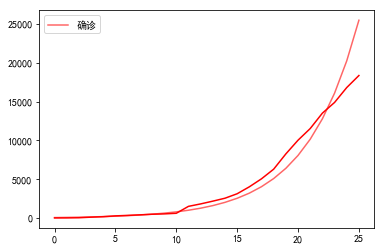

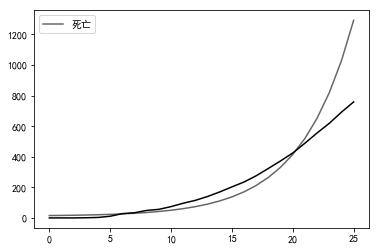

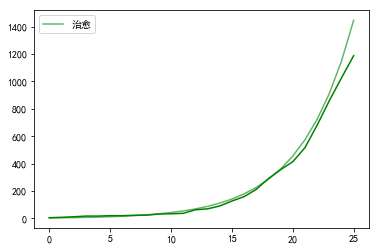

 - 平均潜伏期为：5.40天
 - 病毒再生基数：2.39
 - 确诊R2：0.9082
 - 死亡R2：0.6594
 - 治愈R2：0.9676
 - 模型R2：0.8450
 - 模型总误差：90.5917


In [33]:
train = wuhan['新增确诊', '新增死亡', '新增出院']
train.columns = ['确诊', '死亡', '治愈']
train.accumulate(inplace=True)

def searchBestParam(seir):
    min_loss, max_r2, best_param, likeli_potential = float('inf'),0.0, None, 0
    for potential in range(0, 1100, 25):
        seir.fit(9000000, potential, 45, 15, 2, train)
        loss, r2 = seir.score(9000000, potential, 45, 15, 2, Y=train)
        if loss < min_loss and r2 > max_r2:
            print('潜在患者：%.4f | R2：%.4f | 误差： %.6f' % (potential, r2, loss))
            min_loss, max_r2, best_param, likeli_potential = loss, r2, seir.P, potential
    seir.P = best_param
    seir.score(9000000, likeli_potential, 45, 15, 2, Y=train, plot=True)
    return seir, likeli_potential

seir, potentials = searchBestParam(SEIR())

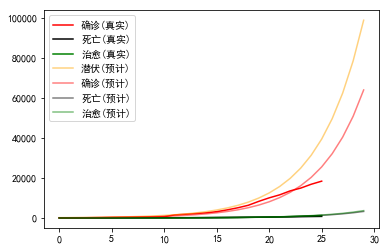

In [34]:
def forcast(seir, T):
    predict = seir.predict(9000000, potentials, 45, 15, 2, T)
    plt.plot(train['确诊'], label='确诊(真实)', color='red')
    plt.plot(train['死亡'], label='死亡(真实)', color='black')
    plt.plot(train['治愈'], label='治愈(真实)', color='green')
    # plt.plot(predict['S'], label='易感(预计)', color='blue', alpha=0.5)
    plt.plot(predict['E'], label='潜伏(预计)', color='orange', alpha=0.5)
    plt.plot(predict['I'], label='确诊(预计)', color='red', alpha=0.5)
    plt.plot(predict['D'], label='死亡(预计)', color='black', alpha=0.5)
    plt.plot(predict['C'], label='治愈(预计)', color='green', alpha=0.5)
    plt.legend()
    plt.show()
forcast(seir, 30)